In [2]:
import torch
import data_v3, data_reg
import numpy as np
import os
import matplotlib.pyplot as plt
import preprocess
import pandas as pd
%matplotlib inline

In [3]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [4]:
def getParameters(model):
    # load vocab & file index  
    if 'cda' in model:
        path = '/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_cda/data'
        vocab = preprocess.read_vocab(os.path.join('/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_cda','VOCAB.txt'))
        idx_train = pd.read_json('../data/idx_train_cda.json')
        idx_val = pd.read_json('../data/idx_val_cda.json')
        idx_test = pd.read_json('../data/idx_test_cda.json')       
    else:
        path = '/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_50000/data'
        vocab = preprocess.read_vocab(os.path.join('/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_50000','VOCAB.txt'))
        idx_train = pd.read_json('../data/idx_train.json')
        idx_val = pd.read_json('../data/idx_val.json')
        idx_test = pd.read_json('../data/idx_test.json')
        
    if 'reg' in model:
        return path, vocab, idx_train, idx_val, idx_test
           
    vocab.append('<eos>')
    words2idx = {item : index for index, item in enumerate(vocab)}
           
    return path, vocab, words2idx, idx_train, idx_val, idx_test

In [5]:
cuda = False
seed = 20190328
#dataDir = './data/wikitext-2'
#words = 10000
#temperature = 1.0
#log_interval = 500

In [6]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if cuda else "cpu")

In [32]:
def getIdx(sentence,checkpoint):
    tok = sentence.split()
    if 'reg' in checkpoint:
        idx = torch.LongTensor([[corpus.dictionary.word2idx[t] for t in tok]]).t().to(device)
    else:
        idx = torch.LongTensor([[corpus.words2idx[t] for t in tok]]).t().to(device)
    return idx

In [8]:
femaleFile = '/Users/zhangben/Desktop/NLU_project/LM_bias/evaluate/gender_words/female_word_file.txt'
maleFile = '/Users/zhangben/Desktop/NLU_project/LM_bias/evaluate/gender_words/male_word_file.txt'

def getGenderIdx(femaleFile, maleFile, words2idx):
    female_word_list = load_doc(femaleFile).split('\n')
    male_word_list = load_doc(maleFile).split('\n')
    #print(len(female_word_list),len(male_word_list))
    pairs = [ (words2idx[f],words2idx[m]) for f,m in zip(female_word_list,male_word_list) \
             if f in words2idx and m in words2idx]
    femaleIdx = [ f for f,m in pairs]
    maleIdx = [ m for f,m in pairs]
    print('gender pairs: ',len(femaleIdx))
    return femaleIdx,maleIdx

In [9]:
def logRatioLossFast(output, f_onehot, m_onehot):
        flato = output.view(-1, ntokens)
        m1 = torch.matmul(m_onehot,flato.t())
        m2 = torch.matmul(f_onehot,flato.t())
        avg_loss = torch.mean(torch.log((torch.exp(m1) + 0.00001) / (torch.exp(m2) + 0.00001)))
        abs_loss = torch.mean(torch.abs(torch.log((torch.exp(m1) + 0.00001) / (torch.exp(m2) + 0.00001))))
        return abs_loss.item(), avg_loss.item()

In [10]:
def getBias(model,idx):

    hidden = model.init_hidden(1)
    output, hidden = model(idx, hidden)
    dist = output[idx.shape[0]-1][0]
    
    absbias,avgbias = logRatioLossFast(output, f_onehot, m_onehot)
    return absbias,avgbias

In [11]:
def getUpper(word):
    #print(word)
    word = word[0].upper() + word[1:]
    return word

In [12]:
#try this if bugs exist wechat Yusu
Occupations =['accountant','actuary','advisor','aide','ambassador','animator','archer','artist','astronaut',
          'astronomer','athlete','attorney','auctioneer','author',
         'babysitter','baker','ballerina','banker','barber','baseball player','basketball player','bellhop',
          'biologist','blacksmith','bookkeeper','bowler','builder','butcher','butler',
         'cab driver','calligrapher','captain','cardiologist','caregiver','carpenter','cartographer','cartoonist','cashier',
          'catcher','caterer','cellist','chaplain','chauffeur','chef','chemist','clerk','coach',
          'cobbler','composer','concierge','consul','contractor','cook','cop','coroner','courier','cryptographer','custodian',
         'dancer','dentist','deputy','dermatologist','designer','detective','dictator','director','disc jockey','diver',
          'doctor','doorman','driver','drummer','dry cleaner',
         'ecologist','economist','editor','educator','electrician','emperor','empress','engineer','entertainer',
          'entomologist','entrepreneur','executive','explorer','exporter','exterminator',
         'falconer','farmer','financier','firefighter','fisherman','flutist','football player','foreman',
         'game designer','garbage man','gardener','gatherer','gemcutter','general',
          'geneticist','geographer','geologist','golfer','governor','grocerguide',
         'hairdresser','handyman','harpist','highway patrol','hobo','hunter',
         'illustrator','importer','instructor','intern','internist','interpreter','inventor','investigator',
          'jailer','janitor','jester','jeweler','jockey','journalist','judge',
          'laborer','landlord','landscaper','laundress','lawyer','lecturer','legal aide','librarian','librettist','lifeguard',
          'linguist','lobbyist','locksmith','lyricist',
          'magician','maid','mail carrier','manager','manufacturer','marine','marketer','mason','mathematician','mayor',
          'mechanic','messenger','miner','model','muralist','musician',
          'navigator','negotiator','notary','novelist','nurse',
          'oboist','operator','ophthalmologist','optician','oracle','orderly','ornithologist',
          'painter','paleontologist','paralega','lpark ranger','pathologist','pawnbroker','peddler','pediatrician','percussionist',
          'performer','pharmacist','philanthro','pistphilosopher','photographer','physician','physicist','pianist','pilot',
          'pitcher','plumber','poet','police','policeman','policewoman','politician','president','prince','princess','principal',
          'private','private detective','producer','professor','programmer','psychiatrist','psychologist','publisher',
          'quarterback','quilter',
          'radiologist','rancher','ranger','real estate agent','receptionist','referee','registrar','reporter',
          'representative','researcher','restaurateur','retailer','retiree',
          'sailor','salesperson','samurai','saxophonist','scholar','scientist','scout','scuba diver','seamstress',
          'security guard','senator','sheriff','singer','smith','socialite','soldier','spystar','statistician','stockbroker',
          'street sweeper','student','surgeon','surveyor','swimmer',
          'tailor','tax collector','taxi driver','taxidermist','teacher','technician','tennis player','test pilot',
          'tiler','toolmaker','trader','trainer','translator','trash collector','travel agent','treasurer','truck driver','tutor','typist',
          'umpire','undertaker','usher',
          'valet','veteran','veterinarian','vicar','violinist',
          'waiter','waitress','warden','warrior','watchmaker','weaver','welder','woodcarver','workman','wrangler','writer',
          'xylophonist',
          "yodeler",
          'zookeeperzoologist'
              ]
Occupations += [getUpper(w) for w in Occupations if len(w)>0]
len(Occupations)

576

In [13]:
def getSentence(template):
    labels = []
    sentences = []
    for i in range(len(occupations)):
        s = occupations[i]+template
        labels.append(occupations[i])
        sentences.append(s)
    for i in range(len(occupations)):
        s = 'the ' + occupations[i]+template
        labels.append(occupations[i])
        sentences.append(s)   
    return sentences, labels

In [34]:
def getTotBias(checkpoint):
    with open(checkpoint, 'rb') as f:
        if cuda:
            model = torch.load(f).to(device)
        else:
            # mapping to cpu device for a gpu trained model
            model = torch.load(f, map_location={'cuda:0': 'cpu'}) #map_location=lambda storage, location: 'cpu'
    model.eval()
    absbiasList = []
    avgbiasList = []
    for s in sentences:
        idx = getIdx(s,checkpoint)
        absbias,avgbias = getBias(model,idx)
        absbiasList.append(absbias)
        avgbiasList.append(avgbias)
    return absbiasList,avgbiasList 

In [15]:
templates = [' is a', ' was a']

In [44]:
modelDir = '../savedmodel/'
modelFiles = [m for m in os.listdir(modelDir) if m.endswith('.pt')]
modelFiles

['lambda_1.pt',
 'lambda_5.pt',
 'reg_0.5.pt',
 'cda.pt',
 'reg_0.1.pt',
 'lambda_0.8.pt',
 'lambda_0.01.pt',
 'lambda_10.pt',
 'lambda_8.pt',
 'lambda_0_baseline.pt',
 'lambda_0.5.pt',
 'lambda_0.1.pt',
 'lambda_2.pt',
 'reg_0.8.pt',
 'glove.pt']

In [45]:
biasList = []
biasDist = []
for m in modelFiles:
    print('processing: ',m)
    if 'reg' in m:
        path, vocab, idx_train, idx_val, idx_test = getParameters(m)
        corpus = data_reg.Corpus(path, vocab, idx_train, idx_val, idx_test)
        ntokens = len(corpus.dictionary)
        femaleIdx,maleIdx = getGenderIdx(femaleFile, maleFile, corpus.dictionary.word2idx)
        occupations = [o for o in Occupations if o in corpus.dictionary.word2idx]
        print('occupations: ',len(occupations))
    else:    
        path, vocab, words2idx, idx_train, idx_val, idx_test = getParameters(m)
        corpus = data_v3.Corpus(path, vocab, words2idx, idx_train, idx_val, idx_test)
        ntokens = len(vocab)
        femaleIdx,maleIdx = getGenderIdx(femaleFile, maleFile, corpus.words2idx)
        occupations = [o for o in Occupations if o in corpus.words2idx]
        print('occupations: ',len(occupations))

    f_onehot = np.zeros((len(femaleIdx), ntokens))
    f_onehot[np.arange(len(femaleIdx)), femaleIdx] = 1
    f_onehot = torch.tensor(f_onehot, dtype = torch.float).to(device)

    m_onehot = np.zeros((len(femaleIdx), ntokens))
    m_onehot[np.arange(len(femaleIdx)), maleIdx] = 1
    m_onehot = torch.tensor(m_onehot, dtype = torch.float).to(device)
    
    # depends on getSentence function
    templateLabels = []
    sentences = []
    for t in templates:
        sent,label = getSentence(t)
        sentences += sent
        templateLabels += label
    print('templates: ',len(sentences))
    
    checkpoint = modelDir+m
    absbiasList,avgbiasList = getTotBias(checkpoint)
    biasList.append( (sum(absbiasList)/len(absbiasList),sum(avgbiasList)/len(avgbiasList)) )
    biasDist.append(list(zip(templateLabels,avgbiasList)))
    print(  (sum(absbiasList)/len(absbiasList),sum(avgbiasList)/len(avgbiasList))  )

processing:  lambda_1.pt
gender pairs:  120
occupations:  213
templates:  852


/Users/zhangben/anaconda/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(0.00032779309624519654, 4.0323108798345306e-05)
processing:  lambda_5.pt
gender pairs:  120
occupations:  213
templates:  852
(4.108858342454501e-05, 3.4157920307840337e-06)
processing:  reg_0.5.pt
gender pairs:  120
occupations:  213
templates:  852
(1.9466021510077194, 0.12357965991884239)
processing:  cda.pt
gender pairs:  166
occupations:  212
templates:  848
(0.7033069122512385, 0.055850775030537404)
processing:  reg_0.1.pt
gender pairs:  120
occupations:  213
templates:  852
(2.0040450615222465, 0.08378220230546815)
processing:  lambda_0.8.pt
gender pairs:  120
occupations:  213
templates:  852
(0.000588911597704692, 8.675837143026659e-05)
processing:  lambda_0.01.pt
gender pairs:  120
occupations:  213
templates:  852
(0.11078713153939292, 0.036825046941654796)
processing:  lambda_10.pt
gender pairs:  120
occupations:  213
templates:  852
(5.9956054407417306e-05, -4.198855300918889e-06)
processing:  lambda_8.pt
gender pairs:  120
occupations:  213
templates:  852
(2.66084658962

In [100]:
biasMod = [b[0] for b in biasList]
biasAvg = [b[1] for b in biasList]

In [95]:
modelNames = ['.'.join(m.split('.')[:-1]) for m in modelFiles]
print(modelNames)

['lambda_1', 'lambda_5', 'reg_0.5', 'cda', 'reg_0.1', 'lambda_0.8', 'lambda_0.01', 'lambda_10', 'lambda_8', 'lambda_0_baseline', 'lambda_0.5', 'lambda_0.1', 'lambda_2', 'reg_0.8', 'glove']


In [102]:
## Just arranging model names by lambda
mm = sorted(modelNames)
biasMod_s = [dict(zip(modelNames,biasMod))[m] for m in mm]
biasAvg_s = [dict(zip(modelNames,biasAvg))[m] for m in mm]
biasDist_s = [dict(zip(modelNames,biasDist))[m] for m in mm]

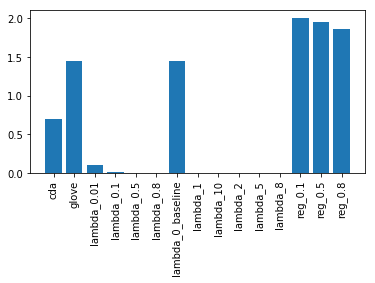

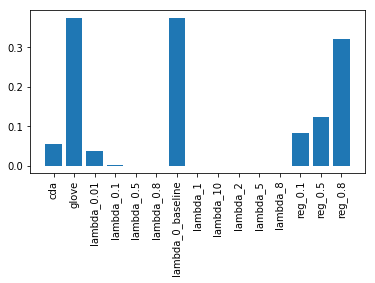

In [104]:
plt.figure(figsize=(6,3))
plt.bar(mm, biasMod_s)
_=plt.xticks(mm, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(mm, biasAvg_s)
_=plt.xticks(mm, rotation='vertical')

In [106]:
# biasDict = []
# for i in range(len(modelsNames)):
#     bDist = biasDist_s[i]
#     bdict = {}
#     countDict = {}
#     for b in bDist:
#         if b[0] in bdict:
#             countDict[b[0]] += 1
#             bdict[b[0]] += b[1]
#         else:
#             bdict[b[0]] = b[1]
#             countDict[b[0]] = 1
    
#     for b in bdict:
#         bdict[b] /= countDict[b]
#     biasDict.append(bdict)

TypeError: unsupported operand type(s) for /=: 'str' and 'int'

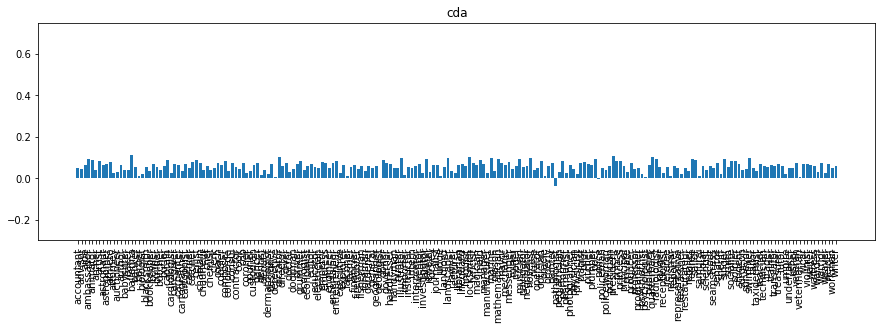

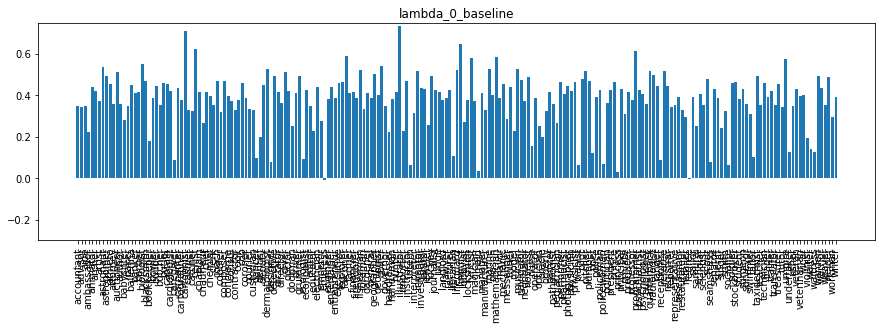

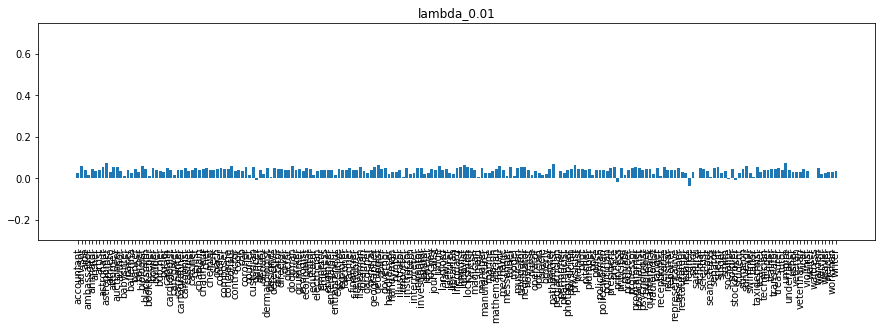

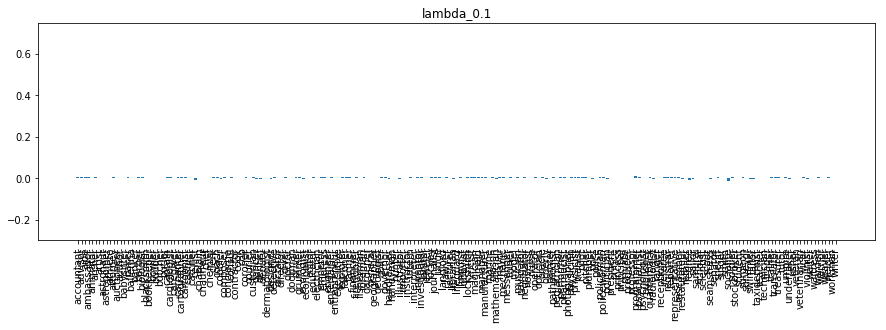

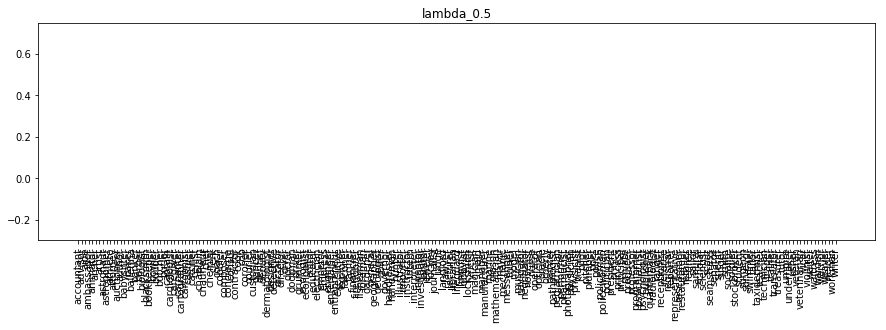

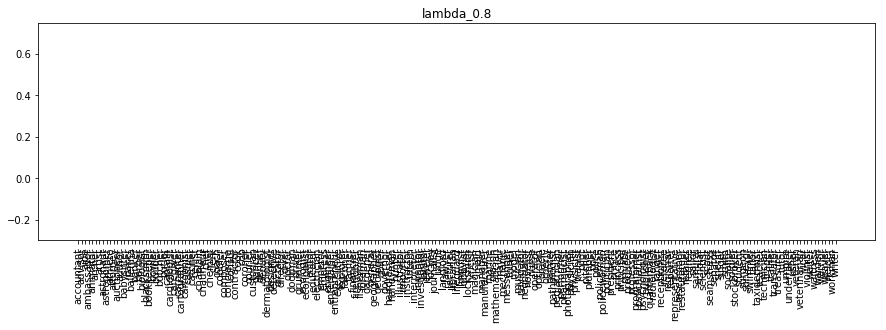

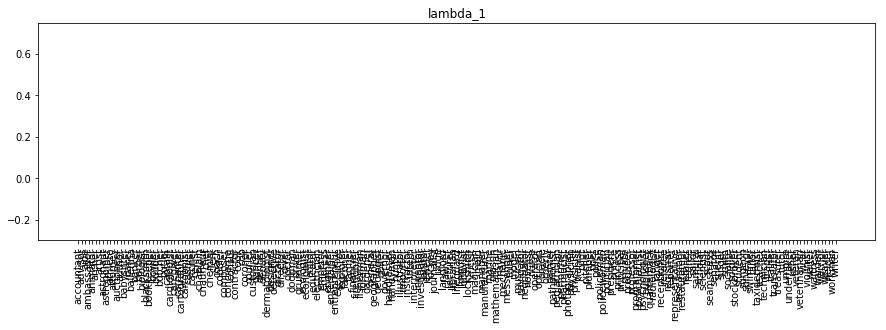

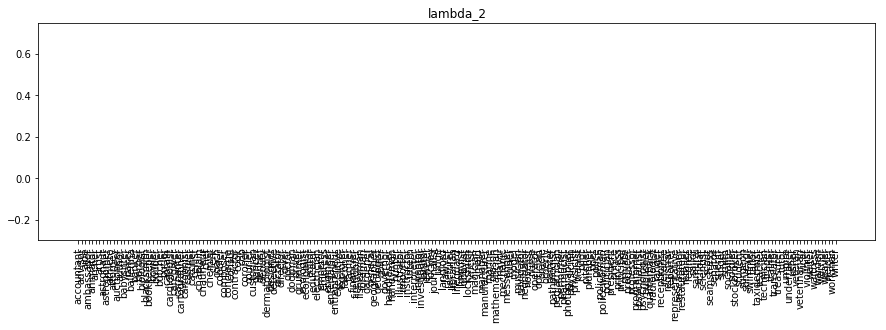

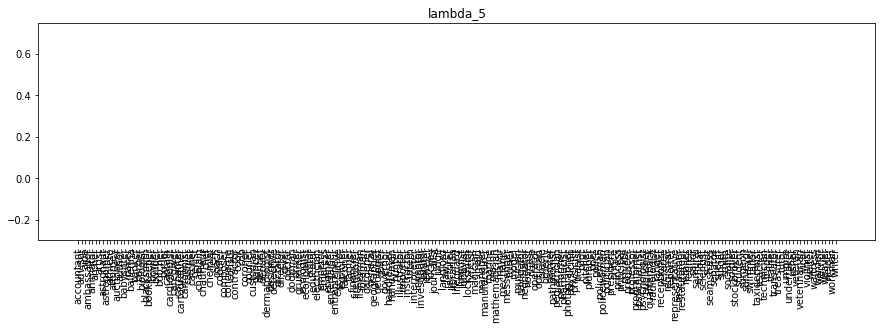

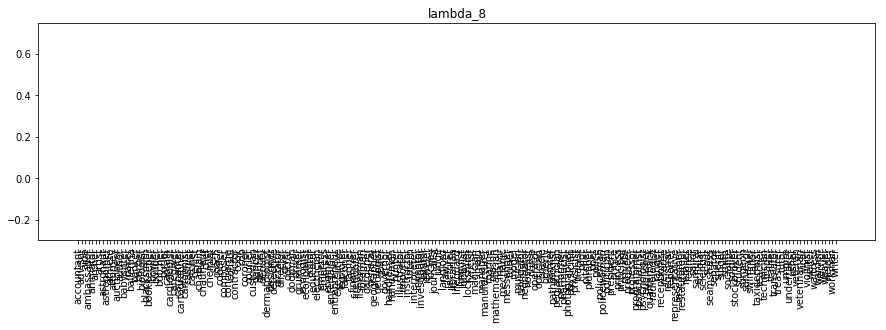

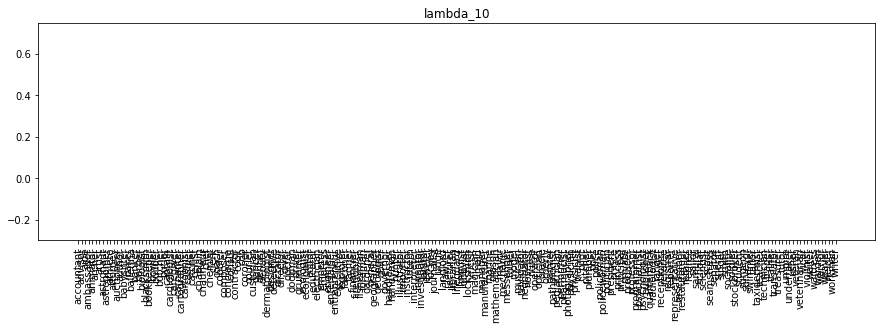

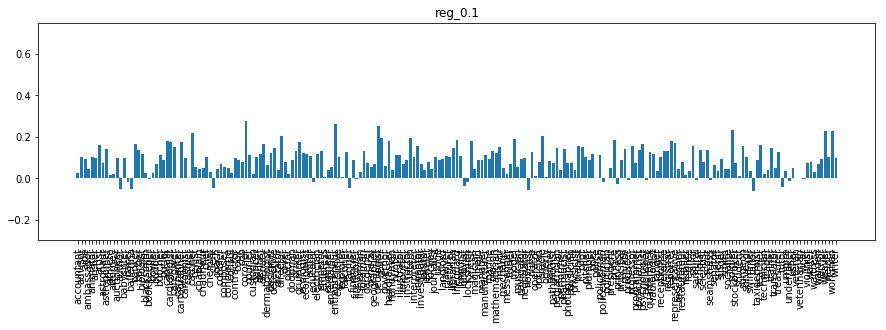

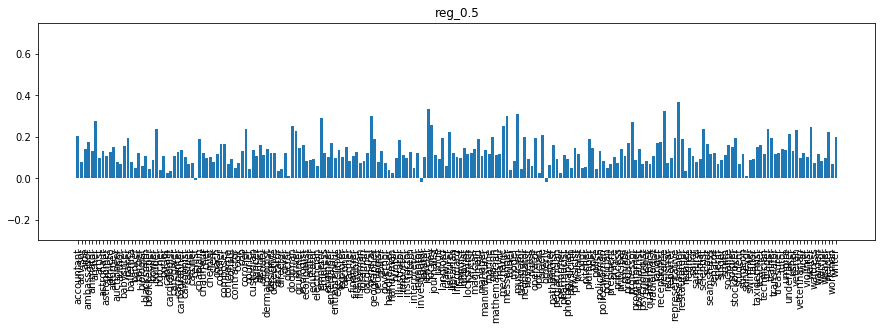

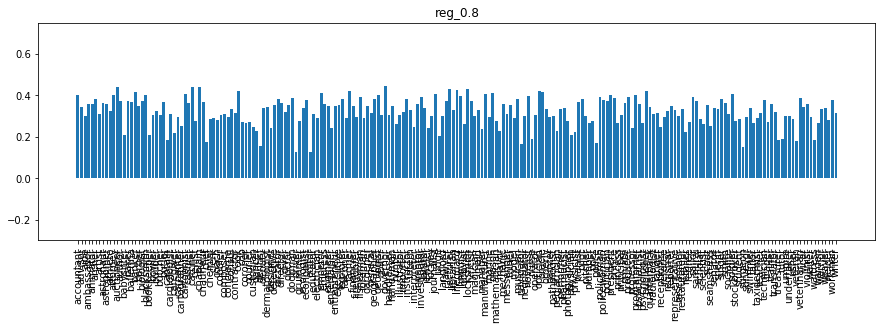

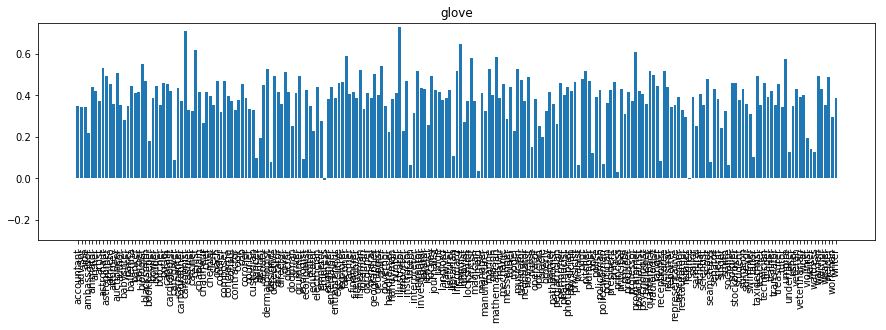

In [51]:
# #biasDist
# for i in range(len(modelsNames)):
#     bdict = biasDict[i]
#     plt.figure(figsize=(15,4))
#     plt.bar(list(bdict.keys()), list(bdict.values()))
#     plt.title(modelsNames[i])
#     plt.ylim((-0.3,0.75))
#     _=plt.xticks(list(bdict.keys()), rotation='vertical')